# Homework 1: Classifiers


# Linear Softmax Classifier

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Load and preprocess CIFAR-10 dataset

In [ ]:
from keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000,
                     num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # All the data comes in the uint8 format, so we need to convert
    # it to floats so that we compute numbers greater than 255.
    X_train = X_train.astype(np.float)
    X_test = X_test.astype(np.float)
    # Also, for convenience we flatten the class arrays.
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # # Split the data into train, val, and test sets. In addition we will
    # # create a small development set as a subset of the training data;
    # # we can use this for development so our code runs faster.
    
    # # Our validation set will be num_validation points from the original
    # # training set.
    mask = list(range(num_training, num_training + num_validation))  # 49000~49999(total 1000)
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    # # Our training set will be the first num_train points from the original
    # # training set.
    mask = list(range(num_training))  # 0~48999(total 49000)
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # # We will also make a development set, which is a small subset of
    # # the training set.

    # equivalent to np.random.permutation(np.arange(49000))[:500]
    mask = np.random.choice(num_training, num_dev, replace=False)  # 49000, 500
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # # We use the first num_test points of the original test set as our
    # # test set.
    mask = list(range(num_test))  # 0~1000
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # # Preprocessing: reshape the image data into rows
    # print()
    # print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    # print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
    
    # # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # # third: append the bias dimension of ones (i.e. bias trick) so that our SVM
    # # only has to worry about optimizing a single weight matrix W.
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    # print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
    # print()
    # print(X_train[:5])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

170508288/170498071 [==============================] - 2s 0us/step
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Define a naive Softmax classifier loss function

Next we define the Softmax loss function.  This will be a naive implementation using loops.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

Recall that the contribution of a training point $(x_i, y_i)$ to the Softmax loss function is

$$L_i = -\log \left( \frac{\exp(s_{y_i})}{\sum_{j} \exp(s_j)} \right) = \log \left( {\sum_{j} \exp(s_j)} \right)-s_{y_i}$$

This is the cross-entropy between the predicted class probabilities, and the distribution with all probability concentrated at $y_i$.  The score $s$ is again parametrized by a linear function $s_j = xW_j$ where $x$ is a single data sample and $W_j$ is the $j$th column of $W$.

In [ ]:
def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    # print(dW.shape)
    # print(W.shape)
    # print(X.shape)
    # print(y.shape)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # n is the number of samples, k is the number of classes.
    n, k = X.shape[0], W.shape[1]  
    for i in range(n):
        for j in range(k):
            logit = np.dot(X[i], W)
            logit -= np.max(logit)
            # print(logit.shape)
            s = sum(np.exp(logit))
            # print(softmax)
            # print(softmax[j])
            # print(sum(softmax))
            # print(sdfghjk)
            loss += int(y[i]==j) * (np.log(s)-logit[j])
            dW[:, j] += X[i] * (np.exp(logit[j])/s - int(y[i]==j))
            # print('here', dW[:, j].shape, (softmax[j]*X[i]).shape)
            # print(sdfghj)
            
    # add regularization
    loss = loss / n + 0.5 * reg * np.sum(W * W)
    dW = dW / n + reg * W
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.382162
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.

**Your answer:** *Fill this in*


In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([np.random.randint(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))
    
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.169709 analytic: 2.169709, relative error: 2.327980e-08
numerical: -0.328164 analytic: -0.328164, relative error: 2.227313e-07
numerical: -1.733892 analytic: -1.733892, relative error: 1.863405e-08
numerical: 2.116874 analytic: 2.116874, relative error: 3.577294e-09
numerical: 0.878519 analytic: 0.878519, relative error: 7.395366e-08
numerical: 0.191263 analytic: 0.191262, relative error: 1.760040e-07
numerical: 1.236772 analytic: 1.236772, relative error: 2.354883e-08
numerical: 1.557530 analytic: 1.557530, relative error: 3.566605e-08
numerical: 1.039594 analytic: 1.039594, relative error: 1.986955e-08
numerical: -0.958055 analytic: -0.958056, relative error: 4.369456e-08
numerical: 0.905420 analytic: 0.905420, relative error: 4.843884e-08
numerical: -1.878834 analytic: -1.878835, relative error: 4.123678e-08
numerical: 0.852154 analytic: 0.852154, relative error: 1.489148e-07
numerical: 0.912481 analytic: 0.912481, relative error: 3.198778e-08
numerical: -0.829202 analy

## Define a vectorized Softmax classifier loss function

Next we define the vectorized (i.e. no loops) version of the Softmax loss function.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    n = X.shape[0]  
    logit = np.dot(X, W)
    logit -= logit.max(axis=1).reshape(n, 1)
    # print(logit.shape)
    s = np.exp(logit).sum(axis=1)
    # print(s.shape)
    # print(logit[range(n), y].shape)
    loss = sum(np.log(s)) - sum(logit[range(n), y])
    softmax = np.exp(logit) / s.reshape(n, 1)
    softmax[range(n), y] -= 1
    dW = np.dot(X.T, softmax)

    # add regularization
    loss = loss / n + 0.5 * reg * np.sum(W * W)
    dW = dW / n + reg * W
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    
    return loss, dW

In [ ]:
# Evaluate the naive implementation of the Softmax gradients

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.382162e+00 computed in 0.478123s
vectorized loss: 2.382162e+00 computed in 0.017847s
Loss difference: 0.000000
Gradient difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Follow the instructions in the TODO sections below.  You may just want to copy the code you wrote for the SVM.

In [ ]:
class Softmax(object):
    def __init__(self):
        self.W = None
    
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
            means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            indices = np.random.choice(a=num_train, size=batch_size, replace=True)
            X_batch = X[indices]
            y_batch = y[indices]
            # print('X_batch.shape', X_batch.shape)
            # print('y_batch.shape', y_batch.shape)
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            self.W -= learning_rate * grad
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))
        
        return loss_history
    
    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
        training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
        array of length N, and each element is an integer giving the predicted
        class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        logit = np.dot(X, self.W)
        y_pred = np.argmax(logit, axis=1)
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred
    
    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
            data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        classifier = Softmax()
        loss_record = classifier.train(X_train, y_train, 
                    learning_rate=lr, reg=reg, 
                    num_iters=1000, verbose=True)
        y_train_hat = classifier.predict(X_train)
        y_val_hat = classifier.predict(X_val)

        if np.mean(y_val == y_val_hat) > best_val:
            best_val = np.mean(y_val == y_val_hat)
            best_softmax = classifier
            
        results[(lr, reg)] = (np.mean(y_train == y_train_hat), np.mean(y_val == y_val_hat))
        # print(len(results), results)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 388.527142
iteration 100 / 1000: loss 235.128589
iteration 200 / 1000: loss 143.046080
iteration 300 / 1000: loss 87.235852
iteration 400 / 1000: loss 53.674269
iteration 500 / 1000: loss 33.229242
iteration 600 / 1000: loss 20.772408
iteration 700 / 1000: loss 13.366945
iteration 800 / 1000: loss 8.849381
iteration 900 / 1000: loss 6.195082
iteration 0 / 1000: loss 766.293861
iteration 100 / 1000: loss 281.526772
iteration 200 / 1000: loss 104.464752
iteration 300 / 1000: loss 39.493778
iteration 400 / 1000: loss 15.773514
iteration 500 / 1000: loss 7.160690
iteration 600 / 1000: loss 3.972997
iteration 700 / 1000: loss 2.668589
iteration 800 / 1000: loss 2.396589
iteration 900 / 1000: loss 2.235025
iteration 0 / 1000: loss 386.235087
iteration 100 / 1000: loss 32.542418
iteration 200 / 1000: loss 4.467566
iteration 300 / 1000: loss 2.165267
iteration 400 / 1000: loss 2.004657
iteration 500 / 1000: loss 1.981396
iteration 600 / 1000: loss 2.006040
iteration 70

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.358000


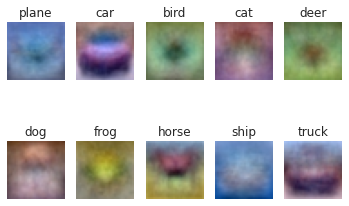

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

*Many thanks to Stanford CS231n for permission to use their materials!*